## Material Categorization through Heat Transfer Analysis with Tensor Decomposition

### Overview

This notebook investigates a heat transfer process governed by a partial differential equation representing heat diffusion over a 2D surface. By applying specific initial and boundary conditions, a series of images (or states) representing the heat distribution at different time points is generated, in effect making a three-dimensional tensor. The task involves analyzing this tensor data to determine the material properties (thermal diffusivity) of an unknown tensor by comparing it with known tensors using CP and Tucker decomposition methods. The aim is to identify the material of the unknown tensor by selecting the optimal decomposition rank through the Akaike Information Criterion (AIC) and to evaluate which decomposition method was more effective in identifying the unknown material.

### Steps

**Intro**

This task has implemented an analytical approach to examine a heat transfer process, modeled by the heat diffusion equation:

$$ \frac{\partial S(x,y,t)}{\partial t} = \alpha \left( \frac{\partial^2 S}{\partial x^2} + \frac{\partial^2 S}{\partial y^2} \right) $$

Here, $S(x,y,t)$ denotes the heat at location $(x, y)$ and time $t$, with $\alpha$ representing the thermal diffusivity coefficient. The domain for $(x, y)$ is confined to $0 \leq x, y \leq 0.05$, capturing the pixel location in an image, and $t$ spans from $1$ to $10$, generating a series of $21 \times 21$ images over ten time frames, cumulatively forming a $21 \times 21 \times 10$ tensor.

**Dataset**

The dataset heatT.mat comprises three tensors:

Tensor 1: Heat transfer in material 1
Tensor 2: Heat transfer in material 2
Tensor 3: An unknown material undergoing heat transfer

**Objective**

The primary goal was to ascertain the material identity of Tensor 3 by comparing its heat transfer characteristics with those of Tensors 1 and 2. This comparison utilized CP and Tucker tensor decomposition techniques, with the Akaike Information Criterion (AIC) guiding the selection of the optimal rank for each decomposition method.

**Methodology and Conclusion**

By employing CP and Tucker decompositions, we analyzed each tensor's structure and extracted features indicative of the underlying material's thermal properties. The optimal decomposition rank was determined through AIC, ensuring the most accurate representation and comparison of thermal dynamics.

The analysis concluded with a comprehensive evaluation of which decomposition method—CP or Tucker—yielded more precise and reliable results in identifying the unknown tensor's material by matching its thermal behavior pattern with that of the known materials.

This investigation not only highlighted the efficacy of tensor decomposition in analyzing complex datasets but also demonstrated its potential in material identification based on thermal diffusion characteristics.

In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorly.decomposition import matrix_product_state
from tensorly.metrics import regression
import tensorly as tl
from tensorly.decomposition import parafac, tucker
from tensorly import tucker_to_tensor
from itertools import product

# Load Tensors
data = loadmat('heatT-1.mat')
tensor1 = data['T1'][0][0][0]
tensor2 = data['T2'][0][0][0]
tensor3 = data['T3'][0][0][0]

### CP Decomposition

#### select optimal rank for CP decomposition

In [3]:
# Define a range of possible ranks. Since lowest dimension of the tensors is 10, that will be my range
rank_range = range(1, 11)

aic_values1 = []
aic_values2 = []
aic_values3 = []

for rank in rank_range:
    # Compute the CP decomposition of each tensor at current rank
    cp_tensor1 = parafac(tensor1, rank=rank)
    cp_tensor2 = parafac(tensor2, rank=rank)
    cp_tensor3 = parafac(tensor3, rank=rank)
    
    # Calculate the reconstructed tensors
    rec_tensor1 = tl.cp_to_tensor(cp_tensor1)
    rec_tensor2 = tl.cp_to_tensor(cp_tensor2)
    rec_tensor3 = tl.cp_to_tensor(cp_tensor3)
    
    # Calculate SSE for each tensor
    sse1 = np.sum((tensor1 - rec_tensor1)**2)
    sse2 = np.sum((tensor2 - rec_tensor2)**2)
    sse3 = np.sum((tensor3 - rec_tensor3)**2)

    # Calculate AIC for each tensor. Using AIC = 2*error + 2*(i+j+k) from notes
    aic1 = 2*sse1 + 2*rank
    aic2 = 2*sse2 + 2*rank
    aic3 = 2*sse3 + 2*rank
    
    aic_values1.append(aic1)
    aic_values2.append(aic2)
    aic_values3.append(aic3)

# Get the ranks with the lowest AIC
optimal_rank1 = rank_range[np.argmin(aic_values1)]
optimal_rank2 = rank_range[np.argmin(aic_values2)]
optimal_rank3 = rank_range[np.argmin(aic_values3)]

print("Optimal rank for tensor 1 is", optimal_rank1, f'with AIC = {min(aic_values1)}')
print("Optimal rank for tensor 2 is", optimal_rank2, f'with AIC = {min(aic_values2)}')
print("Optimal rank for tensor 3 is", optimal_rank3, f'with AIC = {min(aic_values3)}')

Optimal rank for tensor 1 is 10 with AIC = 90.62446531459909
Optimal rank for tensor 2 is 6 with AIC = 90.46005036833986
Optimal rank for tensor 3 is 10 with AIC = 91.06426374168336


#### compute CP decomposition and then AIC for each tensor, then evaluate reconstruction error to classify tensor3

In [4]:
# Compute the CP decomposition of each tensor
cp_tensor1 = parafac(tensor1, rank=optimal_rank1)
cp_tensor2 = parafac(tensor2, rank=optimal_rank2)
cp_tensor3 = parafac(tensor3, rank=optimal_rank3)

In [5]:
# Compute the AIC for each tensor
aic_tensor1 = tl.cp_to_tensor(cp_tensor1)
aic_tensor2 = tl.cp_to_tensor(cp_tensor2)
aic_tensor3 = tl.cp_to_tensor(cp_tensor3)

In [6]:
# Compute the tensor reconstruction error
reconstruction_error1 = ((tensor3 - aic_tensor1)**2).mean()
reconstruction_error2 = ((tensor3 - aic_tensor2)**2).mean()

if reconstruction_error1 < reconstruction_error2:
    print("Tensor 3 corresponds to material 1")
else:
    print("Tensor 3 corresponds to material 2")

Tensor 3 corresponds to material 1


#### graph true tensors and reconstructed CP tensors

TT = True Tensor
RT = Reconstructed Tensor
-----------------------------------------------------------


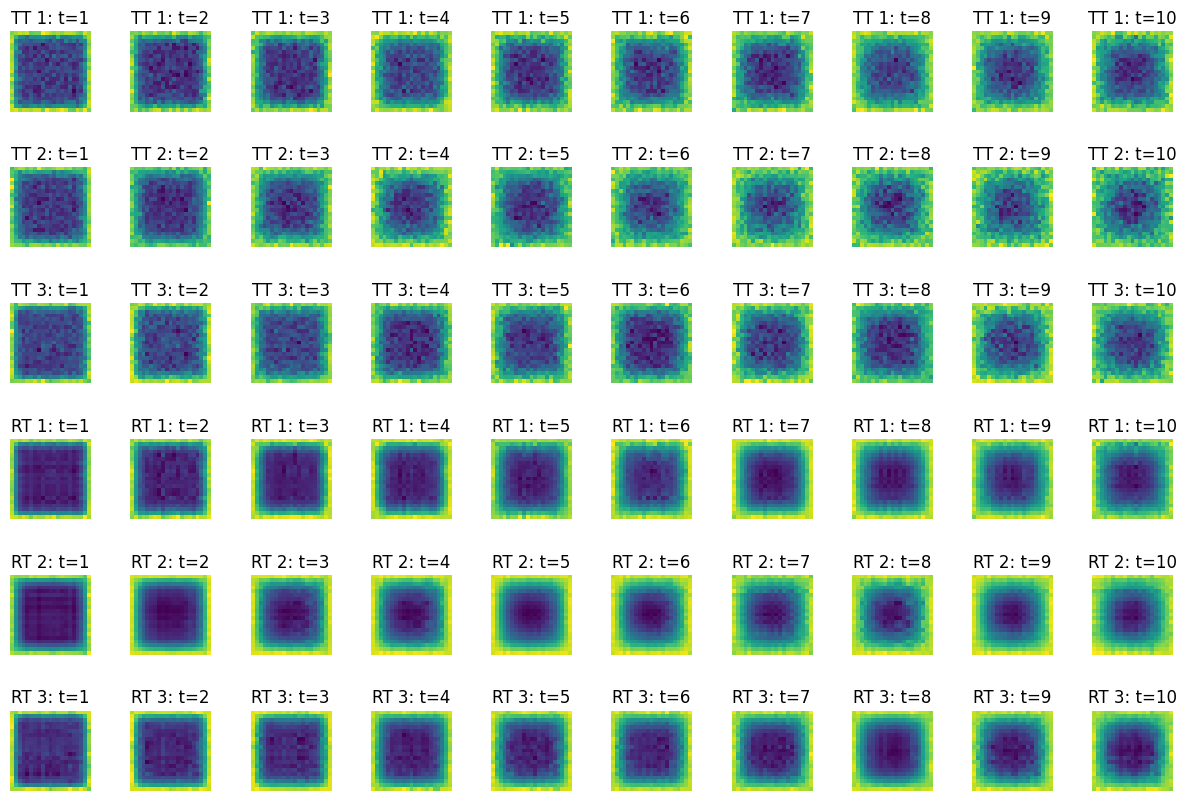

In [7]:
print("TT = True Tensor")
print("RT = Reconstructed Tensor")
print("-----------------------------------------------------------")

t = 10

fig, axs = plt.subplots(6, t, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(t):
    # True tensors
    axs[0, i].imshow(tensor1[:, :, i])
    axs[0, i].axis('off')
    axs[0, i].set_title('TT 1: t=' + str(i+1))

    axs[1, i].imshow(tensor2[:, :, i])
    axs[1, i].axis('off')
    axs[1, i].set_title('TT 2: t=' + str(i+1))
    
    axs[2, i].imshow(tensor3[:, :, i])
    axs[2, i].axis('off')
    axs[2, i].set_title('TT 3: t=' + str(i+1))
    
    # Reconstructed tensors
    axs[3, i].imshow(aic_tensor1[:, :, i])
    axs[3, i].axis('off')
    axs[3, i].set_title('RT 1: t=' + str(i+1))

    axs[4, i].imshow(aic_tensor2[:, :, i])
    axs[4, i].axis('off')
    axs[4, i].set_title('RT 2: t=' + str(i+1))

    axs[5, i].imshow(aic_tensor3[:, :, i])
    axs[5, i].axis('off')
    axs[5, i].set_title('RT 3: t=' + str(i+1))


### Tucker Decomposition

#### find optimal ranks for tucker decomposition by minimizing AIC

In [8]:
# Define a range of possible ranks for each dimension
rank_range1 = range(1, 22) 
rank_range2 = range(1, 22) 
rank_range3 = range(1, 11)

# Generate all possible combinations of ranks
rank_combinations = list(product(rank_range1, rank_range2, rank_range3))

aic_values1 = []
aic_values2 = []
aic_values3 = []

for ranks in rank_combinations:
    core1, factors1 = tucker(tensor1, ranks)
    core2, factors2 = tucker(tensor2, ranks)
    core3, factors3 = tucker(tensor3, ranks)

    # Calculate the reconstructed tensors
    rec_tensor1 = tucker_to_tensor((core1, factors1))
    rec_tensor2 = tucker_to_tensor((core2, factors2))
    rec_tensor3 = tucker_to_tensor((core3, factors3))

    # Calculate SSE for each tensor
    sse1 = np.sum((tensor1 - rec_tensor1)**2)
    sse2 = np.sum((tensor2 - rec_tensor2)**2)
    sse3 = np.sum((tensor3 - rec_tensor3)**2)

    # Calculate AIC for each tensor. Using AIC = 2*error + 2*(i+j+k) from notes
    aic1 = 2*sse1 + 2*sum(ranks)
    aic2 = 2*sse2 + 2*sum(ranks)
    aic3 = 2*sse3 + 2*sum(ranks)
    
    aic_values1.append(aic1)
    aic_values2.append(aic2)
    aic_values3.append(aic3)

# Get the ranks with the lowest AIC
optimal_ranks1 = rank_combinations[np.argmin(aic_values1)]
optimal_ranks2 = rank_combinations[np.argmin(aic_values2)]
optimal_ranks3 = rank_combinations[np.argmin(aic_values3)]

print('Optimal ranks for Tensor1 is', optimal_ranks1, f'with AIC = {min(aic_values1)}')
print('Optimal ranks for Tensor2 is', optimal_ranks2, f'with AIC = {min(aic_values2)}')
print('Optimal ranks for Tensor3 is', optimal_ranks3, f'with AIC = {min(aic_values3)}')

Optimal ranks for Tensor1 is (3, 3, 3) with AIC = 103.99189577812149
Optimal ranks for Tensor2 is (3, 3, 3) with AIC = 101.96893998221978
Optimal ranks for Tensor3 is (20, 20, 10) with AIC = 103.63577457256034


#### use optimal ranks for tucker decomposition, compare decomposed tensors for material classification, and generate reconstructed tensors

In [9]:
# Perform Tucker decomposition with optimal ranks
core1, factors1 = tucker(tensor1, optimal_ranks1)
core2, factors2 = tucker(tensor2, optimal_ranks2)
core3, factors3 = tucker(tensor3, optimal_ranks3)

# Compare decomposed tensors using Frobenius Norm
diff1 = np.linalg.norm(tl.tucker_tensor.tucker_to_tensor((core3, factors3)) - tl.tucker_tensor.tucker_to_tensor((core1, factors1)))
diff2 = np.linalg.norm(tl.tucker_tensor.tucker_to_tensor((core3, factors3)) - tl.tucker_tensor.tucker_to_tensor((core2, factors2)))

if diff1 < diff2:
    print('Tensor 3 corresponds to Material 1')
else:
    print('Tensor 3 corresponds to Material 2')
    
# Create reconstructed tensors from the Tucker decompositions
rec_tensor1 = tucker_to_tensor((core1, factors1))
rec_tensor2 = tucker_to_tensor((core2, factors2))
rec_tensor3 = tucker_to_tensor((core3, factors3))

Tensor 3 corresponds to Material 1


#### graph true tensors and reconstructed Tucker tensors

TT = True Tensor
RT = Reconstructed Tensor
-----------------------------------------------------------


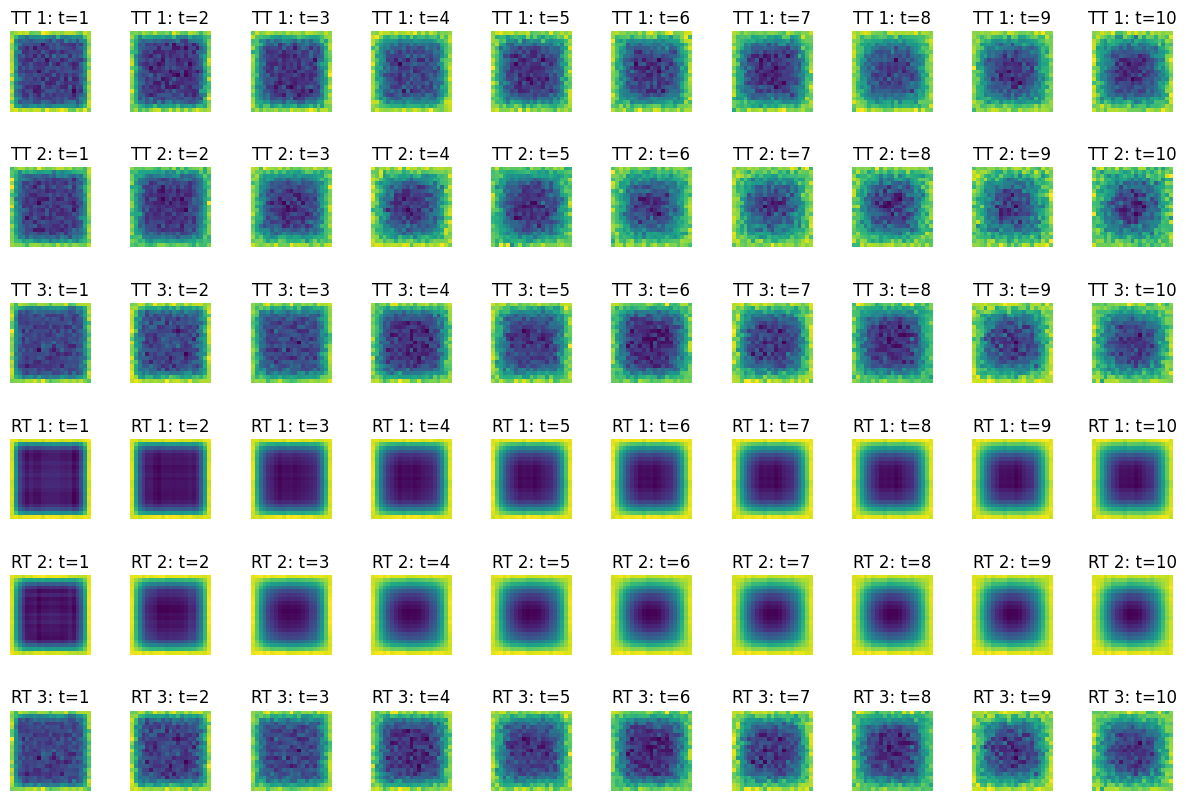

In [10]:
print("TT = True Tensor")
print("RT = Reconstructed Tensor")
print("-----------------------------------------------------------")

t = 10

fig, axs = plt.subplots(6, t, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(t):
    # True tensors
    axs[0, i].imshow(tensor1[:, :, i])
    axs[0, i].axis('off')
    axs[0, i].set_title('TT 1: t=' + str(i+1))

    axs[1, i].imshow(tensor2[:, :, i])
    axs[1, i].axis('off')
    axs[1, i].set_title('TT 2: t=' + str(i+1))
    
    axs[2, i].imshow(tensor3[:, :, i])
    axs[2, i].axis('off')
    axs[2, i].set_title('TT 3: t=' + str(i+1))
    
    # Reconstructed tensors
    axs[3, i].imshow(rec_tensor1[:, :, i])
    axs[3, i].axis('off')
    axs[3, i].set_title('RT 1: t=' + str(i+1))

    axs[4, i].imshow(rec_tensor2[:, :, i])
    axs[4, i].axis('off')
    axs[4, i].set_title('RT 2: t=' + str(i+1))

    axs[5, i].imshow(rec_tensor3[:, :, i])
    axs[5, i].axis('off')
    axs[5, i].set_title('RT 3: t=' + str(i+1))


### Conclusions
----------------------------------
Both of my results from CP decomposition and Tucker decomposition conclude that Tensor 3 comes from Material 1 (The same as Tensor 1). I would have thought that Tucker decomposition would yield a better result because it is more flexible and complex whereas CP decomposition is a sum of rank-1 tensors, but the CP decomposition had lower AIC values so it may have been the more effective tensor decomposition method.